# Model

In [44]:
import pandas as pd

train = pd.read_csv('./data/train.csv', index_col='id')
test = pd.read_csv('./data/test.csv', index_col='id')
train.head()

,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,...,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,T,Y,Green,Triangle,Snake,Finland,Bassoon,...,2f4cb3d51,2,Grandmaster,Cold,h,D,kr,2,2,0
1,0,1,0,T,Y,Green,Trapezoid,Hamster,Russia,Piano,...,f83c56c21,1,Grandmaster,Hot,a,A,bF,7,8,0
2,0,0,0,F,Y,Blue,Trapezoid,Lion,Russia,Theremin,...,ae6800dd0,1,Expert,Lava Hot,h,R,Jc,7,2,0
3,0,1,0,F,Y,Red,Trapezoid,Snake,Canada,Oboe,...,8270f0d71,1,Grandmaster,Boiling Hot,i,D,kW,2,1,1
4,0,0,0,F,N,Red,Trapezoid,Lion,Canada,Oboe,...,b164b72a7,1,Grandmaster,Freezing,a,R,qP,7,8,0


In [45]:
# Feature Engineering 

# From : https://www.kaggle.com/pavelvpster/cat-in-dat-solution-1/

# Use one hot encoding for the features below
ohe_features = ['bin_0', 'bin_1', 'bin_2', 'bin_3', 'bin_4',
                'nom_0', 'nom_1', 'nom_2', 'nom_3', 'nom_4',
                'ord_0', 'ord_1', 'ord_2', 'ord_3', 'ord_4',
                'day', 'month'] 

# Use Label Encoder for the remaining features
le_features = list(set(test.columns) - set(ohe_features))

train_size = len(train)
df = pd.get_dummies(pd.concat([train, test], axis=0, sort=True), columns=ohe_features)
train = df[:train_size]
test = df[train_size:].drop('target', axis=1)
del df

In [48]:
from sklearn.preprocessing import LabelEncoder

def encode_categorial_features_fit(df, columns_to_encode):
    encoders = {}
    for c in columns_to_encode:
        if c in df.columns:
            encoder = LabelEncoder()
            encoder.fit(df[c].astype(str).values)
            encoders[c] = encoder
    return encoders

def encode_categorial_features_transform(df, encoders):
    out = pd.DataFrame(index=df.index)
    for c in encoders.keys():
        if c in df.columns:
            out[c] = encoders[c].transform(df[c].astype(str).values)
    return out


In [49]:
categorical_features_encoders = encode_categorial_features_fit(
    pd.concat([train, test], join='outer', sort=False), le_features)

In [50]:
temp = encode_categorial_features_transform(train, categorial_features_encoders)
columns_to_drop = list(set(le_features) & set(train.columns))
train = train.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)

In [53]:
temp = encode_categorial_features_transform(test, categorial_features_encoders)
columns_to_drop = list(set(le_features) & set(test.columns))
test = test.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
del temp

In [74]:
# Target Encoding ( for categorical features with a high cardinality )

from category_encoders import TargetEncoder

te_features = [
    'nom_5', 'nom_6', 'nom_7', 'nom_8', 'nom_9'
]

te = TargetEncoder(cols=te_features, drop_invariant=True, return_df=True, min_samples_leaf=2, smoothing=1.0)
te.fit(train[te_features], train['target'])

temp = te.transform(train[te_features])
columns_to_drop = list(set(te_features) & set(train.columns))
train = train.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
del temp

temp = te.transform(test[te_features])
columns_to_drop = list(set(te_features) & set(test.columns))
test = test.drop(columns_to_drop, axis=1).merge(temp, how='left', left_index=True, right_index=True)
del temp

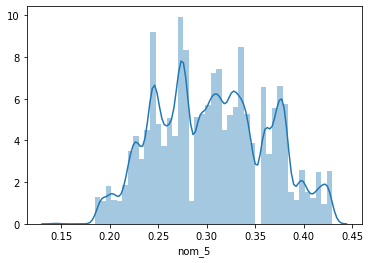

In [84]:
import seaborn as sns

sns.distplot(train['nom_5'])

In [87]:
# Train Model

from xgboost import XGBClassifier

model = XGBClassifier(learning_rate=0.1, n_estimators=140, max_depth=5,
                        min_child_weight=3, gamma=0.2, subsample=0.6, colsample_bytree=1.0,
                        objective='binary:logistic', nthread=4, scale_pos_weight=1, seed=0)

model.fit(train.drop(columns='target'), train['target'], eval_metric='auc')

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1.0, gamma=0.2,
              learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=3, missing=None, n_estimators=140, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=27,
              silent=None, subsample=0.6, verbosity=1)

In [88]:
# Predict on the Test set

y_pred = model.predict(test)

In [93]:
# Create and save submission DF

pred_df = pd.DataFrame({'id': test.index, 'target':y_pred})
pred_df.to_csv('data/submit.csv', index=False)